In [ ]:
# 1. Importing libraries

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

In [ ]:
# 2. Loading the data

In [20]:
def load_json_files(folder, is_weekend=False):
    data = []
    for file in sorted(os.listdir(folder)):
        if file.endswith(".json"):
            df = pd.read_json(os.path.join(folder, file))
            for row in df.itertuples():
                for traffic_entry in row.traffic:
                    data.append({
                        "street_name": row.street_name,
                        "number_of_nearby_pois": row.number_of_nearby_pois,
                        "date": pd.to_datetime(traffic_entry["date"]),
                        "speed": traffic_entry["speed"],  # Now included in features
                        "jamFactor": traffic_entry["jamFactor"],
                        "temperature": traffic_entry.get("temperature", None),
                        "is_weekend": int(is_weekend)
                    })
    return pd.DataFrame(data)

# Load data
weekday_df = load_json_files("data/weekdays", is_weekend=False)
weekend_df = load_json_files("data/weekends", is_weekend=True)

# Combine datasets
df = pd.concat([weekday_df, weekend_df], ignore_index=True)

In [ ]:
# 3. Data Preprocessing

In [21]:
# Extract time-based features (excluding minute)
df["hour"] = df["date"].dt.hour
df["weekday"] = df["date"].dt.weekday



# Group by relevant features (exclude minute)
df_grouped = df.groupby(
    ['street_name', 'number_of_nearby_pois', 'hour', 'weekday', 'is_weekend', 'temperature'],
    as_index=False
).agg({'speed': 'mean', 'jamFactor': 'mean'})  # Taking mean speed per group

print(df_grouped.head(10))
# Apply One-Hot Encoding to street_name
street_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
street_encoded = street_encoder.fit_transform(df_grouped[['street_name']])
street_encoded_df = pd.DataFrame(street_encoded, columns=street_encoder.get_feature_names_out(['street_name']))

# Drop original street_name column and reset index
df_grouped = df_grouped.drop(columns=['street_name']).reset_index(drop=True)

# Concatenate one-hot encoded streets
df_grouped = pd.concat([df_grouped, street_encoded_df], axis=1)


     street_name  number_of_nearby_pois  hour  weekday  is_weekend  \
0  Brennerstraße                      5    12        3           0   
1  Brennerstraße                      5    13        6           1   
2  Brennerstraße                      5    14        4           0   
3  Brennerstraße                      5    15        0           0   
4  Brennerstraße                      5    15        0           0   
5  Brennerstraße                      5    15        0           0   
6  Brennerstraße                      5    15        0           0   
7  Brennerstraße                      5    15        0           0   
8  Brennerstraße                      5    15        1           0   
9  Brennerstraße                      5    15        1           0   

   temperature     speed  jamFactor  
0          6.4  8.333334       2.60  
1          1.6  9.444445       1.20  
2          3.8  8.888889       2.80  
3         -1.9  7.777778       3.70  
4         -1.4  8.472223       1.70  
5

In [ ]:
# Defining Features and Models

In [22]:
# Define features 
features = list(df_grouped.columns)
features.remove("jamFactor")  # Target variable

# Print features used during training
print(f"Training features: {features}")


# Extract features & target
X = df_grouped[features]
y = df_grouped["jamFactor"]

# Handle missing values
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# Define models dictionary
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

# Define K-Fold Cross-Validation (5 Folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


Training features: ['number_of_nearby_pois', 'hour', 'weekday', 'is_weekend', 'temperature', 'speed', 'street_name_Brennerstraße', 'street_name_Feldkirchenstraße', 'street_name_Lichtenhaidestraße', 'street_name_Ludwigstraße', 'street_name_Margaretendamm', 'street_name_Memmelsdorfer Straße', 'street_name_Siechenstraße']


In [ ]:
# 5. Training and Evaluating Models

Evaluating model: RandomForest
Mean MAE: 0.2508
Mean R² Score: 0.8131
----------------------------------------


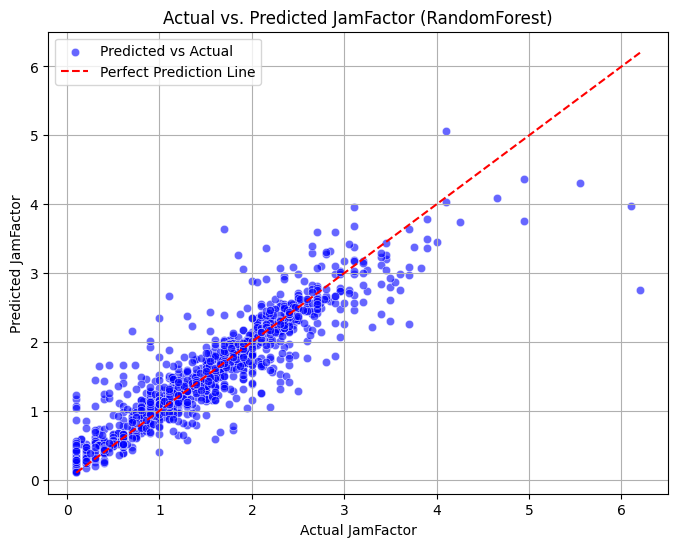

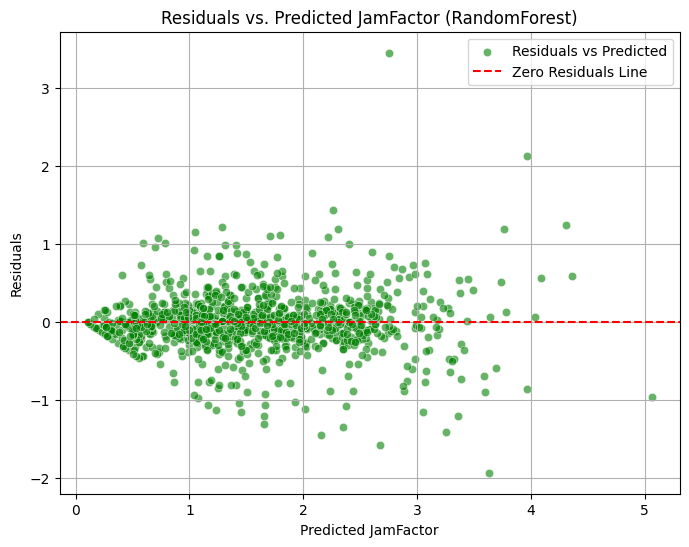

Evaluating model: XGBoost
Mean MAE: 0.2749
Mean R² Score: 0.777
----------------------------------------


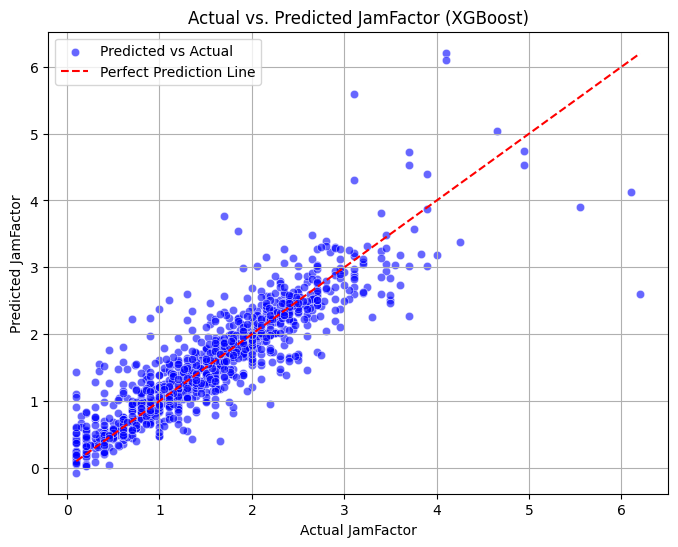

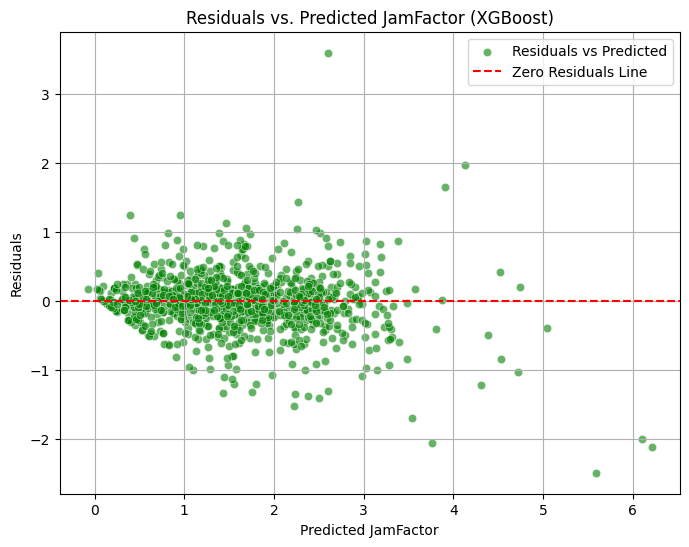

Evaluating model: GradientBoosting
Mean MAE: 0.2783
Mean R² Score: 0.8049
----------------------------------------


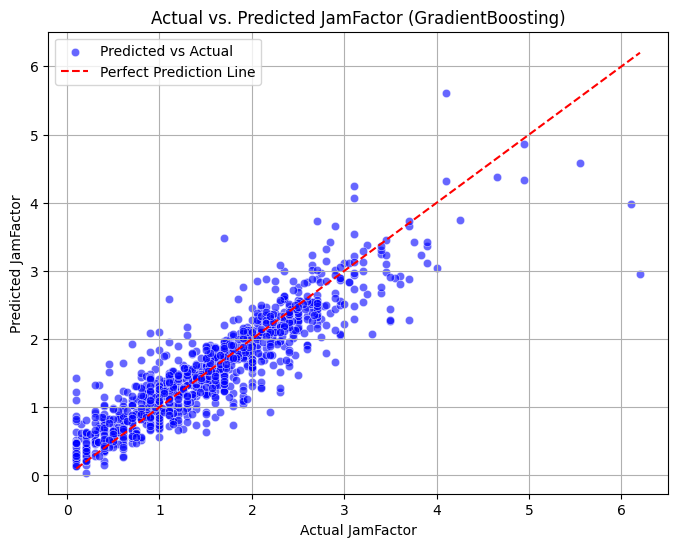

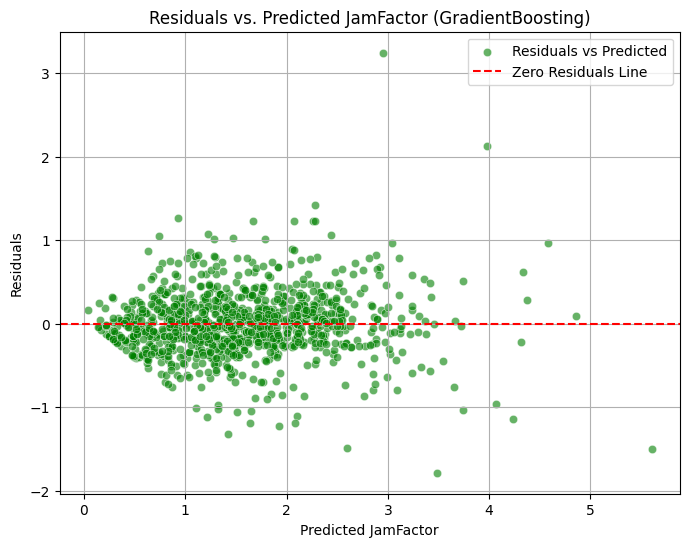

In [23]:
# Run Cross-Validation for the selected model
for name, model in models.items():
    print(f"Evaluating model: {name}")
    
    # Compute Cross-validation Scores (for MAE and R2)
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(mean_absolute_error, greater_is_better=False))
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(r2_score))

    # Print Results
    print(f"Mean MAE: {round(-np.mean(mae_scores), 4)}")  # Convert negative MAE to positive
    print(f"Mean R² Score: {round(np.mean(r2_scores), 4)}")
    print("-" * 40)

    # Get Predictions for Actual vs Predicted Plot
    y_pred = cross_val_predict(model, X, y, cv=kf)

    # Plot Actual vs Predicted Values
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y, y=y_pred, alpha=0.6, color="blue", label="Predicted vs Actual")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="Perfect Prediction Line")
    plt.xlabel("Actual JamFactor")
    plt.ylabel("Predicted JamFactor")
    plt.title(f"Actual vs. Predicted JamFactor ({name})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Residuals vs Predicted Jam Factor
    residuals = y - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color="green", label="Residuals vs Predicted")
    plt.axhline(y=0, color="red", linestyle="--", label="Zero Residuals Line")
    plt.xlabel("Predicted JamFactor")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs. Predicted JamFactor ({name})")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# 6. Prediction Function

In [24]:
# Function to predict Jam Factor for a new set of input features
def predict_jam_factor(street, number_of_nearby_pois, hour, weekday, is_weekend, temperature, speed, model):
    street_encoded = street_encoder.transform([[street]])  # Ensure the same encoder is used here

    input_features = np.array([[number_of_nearby_pois, hour, weekday, is_weekend, temperature, speed]])

    # Stack the street encoded features with the numerical features
    X_input = np.hstack([input_features, street_encoded])
 
    # print(f"Prediction input features: {X_input[0]}")

    # # Print the shape of the prediction input
    # print(f"Prediction input shape: {X_input.shape}")  # 

    # Fit the model before making the prediction
    model.fit(X, y)

    # Use the model to make a prediction
    return model.predict(X_input)[0]


# Prediction with GradientBoosting model
selected_model = models["GradientBoosting"] 

predicted_jam_factor = predict_jam_factor(
    street="Feldkirchenstraße", 
    number_of_nearby_pois=5,
    hour=9,
    weekday=2,  # Tuesday
    is_weekend=0,
    temperature=5.0,
    speed=10.0,
    model=selected_model
)

print(f"Predicted Jam Factor: {predicted_jam_factor:.2f}")




c:\Users\qasim\Desktop\Mobi-Project\UniBam-MOBI-Project\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Predicted Jam Factor: 1.46
